## 15 Evaluate Element Counts
Each model is evaluated on how well it's able to produce the correct element counts after using the predicted fitting parameters with XRF-Maps compared to the experimental values.

In [1]:
import pandas as pd
import numpy as np
import pyxrfmaps as px 
import matplotlib.pyplot as plt
import pickle
import xgboost
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

In [2]:
spectra = pd.read_csv('./training_data/07_test_int_spectra.csv', header=None)
normalized_spectra = pd.read_csv('./training_data/08_test_int_spectra.csv', header=None)
fit_params_to_predict = pd.read_csv('./training_data/04_fit_params_to_predict.csv')
fit_params_constant = pd.read_csv('./training_data/04_fit_params_constant.csv')
elements = pd.read_csv('./training_data/07_test_elements.csv')

In [3]:
print(len(spectra))
print(len(elements))

6650
6650


In [4]:
#Drop elements that weren't in the experiments
for col in elements.columns:
    if len(set(elements[col].to_list())) == 1:
        elements.drop(columns=col, inplace=True)

In [7]:
#Load models
xgb_model = pickle.load(open('13_xgboost.sav', 'rb'))
mlp_model = pickle.load(open('13_multilayer_perceptron.sav', 'rb'))
rf_model = pickle.load(open('13_random_forest.sav', 'rb'))

In [8]:
#Predict fitting parameters
xgb_fit_params_predicted = xgb_model.predict(normalized_spectra)
mlp_fit_params_predicted = mlp_model.predict(normalized_spectra)
rf_fit_params_predicted = rf_model.predict(normalized_spectra)

In [9]:
xgb_predicted_df = pd.DataFrame(xgb_fit_params_predicted, columns=fit_params_to_predict.columns)
mlp_predicted_df = pd.DataFrame(mlp_fit_params_predicted, columns=fit_params_to_predict.columns)
rf_predicted_df = pd.DataFrame(rf_fit_params_predicted, columns=fit_params_to_predict.columns)

In [10]:
#Limit SI_ESCAPE_ENABLE to 0 or 1
for df in [xgb_predicted_df, mlp_predicted_df, rf_predicted_df]:
    df['SI_ESCAPE_ENABLE'] = np.where(df['SI_ESCAPE_ENABLE'] < 0.5, 0.0, 1.0)

In [11]:
#Crop the values of predicted fitting parameters to the range seen in experiments
for col in fit_params_to_predict.columns:
    for df in [xgb_predicted_df, mlp_predicted_df, rf_predicted_df]:
        min_val = round(fit_params_to_predict[col].iloc[0], 6)
        max_val = round(fit_params_to_predict[col].iloc[1], 6)
        df[col] = df[col].clip(min_val, max_val)

In [12]:
def get_fitted_element_counts(fit_params, int_spectra, elems):
    element_csv_filename = "../reference/xrf_library.csv"
    element_henke_filename = "../reference/henke.xdr"
    trans = px.io.file.get_FILE_TAGS_TRANSLATION()
    px.load_element_info(element_henke_filename, element_csv_filename)
    # Select fitting routine
    fit_rout = px.fitting.routines.nnls()
    # Use Gaussian Model
    model = px.fitting.models.GaussModel()
    po = px.ParamsOverride()
    po.fill_elements_from_dict(elems, 'Si')

    for name, value in fit_params.items():
        po.fit_params.add_parameter(px.Fit_Param(name, value))
    model.update_fit_params_values(po.fit_params)

    energy_range = px.get_energy_range(int_spectra.size, po.fit_params)
    fit_rout.initialize(model, po.elements_to_fit, energy_range)

    # Fit element counts
    element_counts_fit = fit_rout.fit_counts(model, int_spectra, po.elements_to_fit)
    return element_counts_fit

In [13]:
def score_predictions(predictions):
    predicted_element_counts = elements.copy()
        
    for i in range(len(spectra)):
        elem_names = []
        for col in elements.columns:
            if elements.iloc[i][col] != -1:
                elem_names.append(col)
        predicted_fit_params = dict(predictions.iloc[i])
        predicted_fit_params.update(dict(fit_params_constant.iloc[0]))
        element_counts_fit = get_fitted_element_counts(predicted_fit_params, spectra.iloc[i], elem_names)
        for name in elem_names:
            predicted_element_counts[name].iloc[i] = element_counts_fit[name]
    
    r2_scores = {}
    spear_scores = {}
    for col in elements.columns:
        predicted = predicted_element_counts[predicted_element_counts[col] != -1][col]
        expected = elements[elements[col] != -1][col]
        r2 = r2_score(expected, predicted)
        r2_scores[col] = r2 if r2 >= 0 else 0
        spear = spearmanr(expected, predicted).statistic
        spear_scores[col] = spear if spear >= 0 else 0

    return r2_scores, spear_scores

In [14]:
xgb_r2_scores, xgb_spear_scores = score_predictions(xgb_predicted_df)
mlp_r2_scores, mlp_spear_scores = score_predictions(mlp_predicted_df)
rf_r2_scores, rf_spear_scores = score_predictions(rf_predicted_df)

C:\Users\user2ide\Miniconda3\envs\py3.11\Lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
C:\Users\user2ide\Miniconda3\envs\py3.11\Lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
C:\Users\user2ide\Miniconda3\envs\py3.11\Lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
C:\Users\user2ide\Miniconda3\envs\py3.11\Lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
C:\Users\user2ide\Miniconda3\envs\py3.11\Lib\sit

In [44]:
# Sort the scores on how often the elements appeared in the experiments
sorting_key = lambda item: len(elements[elements[item[0]] > 0][item[0]])
sorted_xgb_r2_scores = dict(sorted(xgb_r2_scores.items(), key=sorting_key))
sorted_mlp_r2_scores = dict(sorted(mlp_r2_scores.items(), key=sorting_key))
sorted_rf_r2_scores = dict(sorted(rf_r2_scores.items(), key=sorting_key))

In [46]:
# Sort the scores on how often the elements appeared in the experiments
sorting_key = lambda item: len(elements[elements[item[0]] > 0][item[0]])
sorted_xgb_spear_scores = dict(sorted(xgb_spear_scores.items(), key=sorting_key))
sorted_mlp_spear_scores = dict(sorted(mlp_spear_scores.items(), key=sorting_key))
sorted_rf_spear_scores = dict(sorted(rf_spear_scores.items(), key=sorting_key))

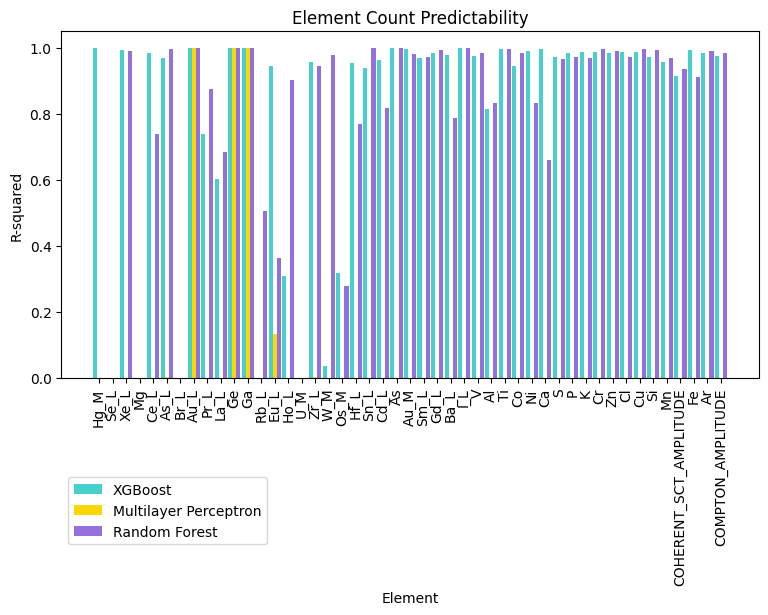

In [80]:
plt.gcf().set_size_inches(9, 4.5)
bar_width = 0.3

bar_positions1 = np.arange(len(elements.columns))
bar_positions2 = bar_positions1 + bar_width
bar_positions3 = bar_positions1 + 2 * bar_width

plt.bar(bar_positions1, sorted_xgb_r2_scores.values(), width=bar_width, color='mediumturquoise', label='XGBoost')
plt.bar(bar_positions2, sorted_mlp_r2_scores.values(), width=bar_width, color='gold', label='Multilayer Perceptron')
plt.bar(bar_positions3, sorted_rf_r2_scores.values(), width=bar_width, color='mediumpurple', label='Random Forest')

plt.xticks(bar_positions2, sorted_xgb_r2_scores.keys(), rotation=90)  

plt.xlabel('Element')
plt.ylabel('R-squared')
plt.title('Element Count Predictability')
plt.legend(loc='lower left', bbox_to_anchor=(0, -0.5))
plt.savefig("elemR2.png", bbox_inches='tight')
plt.show()

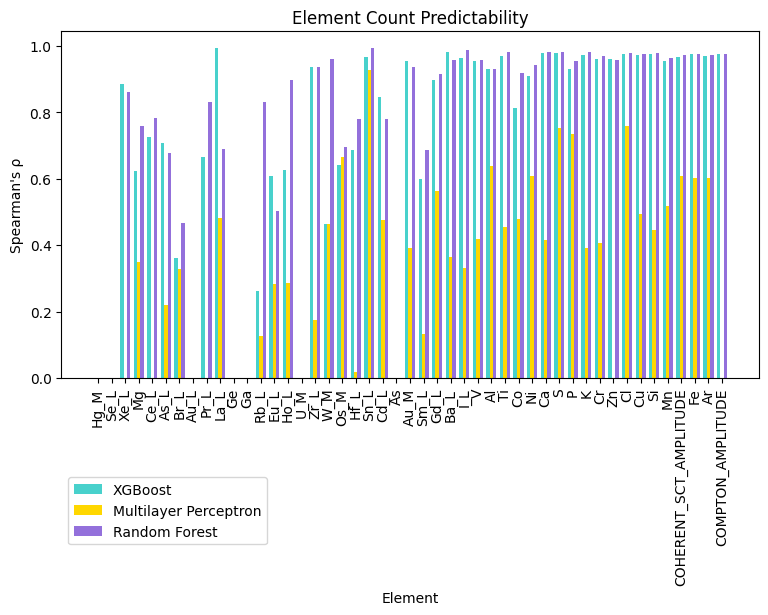

In [79]:
plt.gcf().set_size_inches(9, 4.5)
bar_width = 0.25

bar_positions1 = np.arange(len(elements.columns))
bar_positions2 = bar_positions1 + bar_width
bar_positions3 = bar_positions1 + 2 * bar_width

plt.bar(bar_positions1, sorted_xgb_spear_scores.values(), width=bar_width, color='mediumturquoise', label='XGBoost')
plt.bar(bar_positions2, sorted_mlp_spear_scores.values(), width=bar_width, color='gold', label='Multilayer Perceptron')
plt.bar(bar_positions3, sorted_rf_spear_scores.values(), width=bar_width, color='mediumpurple', label='Random Forest')

plt.xticks(bar_positions2, sorted_xgb_spear_scores.keys(), rotation=90)  

plt.xlabel('Element')
plt.ylabel("Spearman's ρ")
plt.title('Element Count Predictability')
plt.legend(loc='lower left', bbox_to_anchor=(0, -0.5))
plt.savefig("elemSpear.png", bbox_inches='tight')
plt.show()